In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1 - Analysis of the dataset

#### 1.1 - Loading the dataset

In [2]:
df = pd.read_csv("Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.shape

(14640, 15)

So, the dataset contains 14640 entries and has 15 columns. The ones that we are interested in are "airline_sentiment" and "text". It represents the sentiment felt by the author of the tweet about US Airlines. At first glance, I do not think that the other columns are relevant in our project as we do not want the model to overfit on for instance Twitter's username or airline.

#### 1.2 - Frequencies of sentiments in the dataset

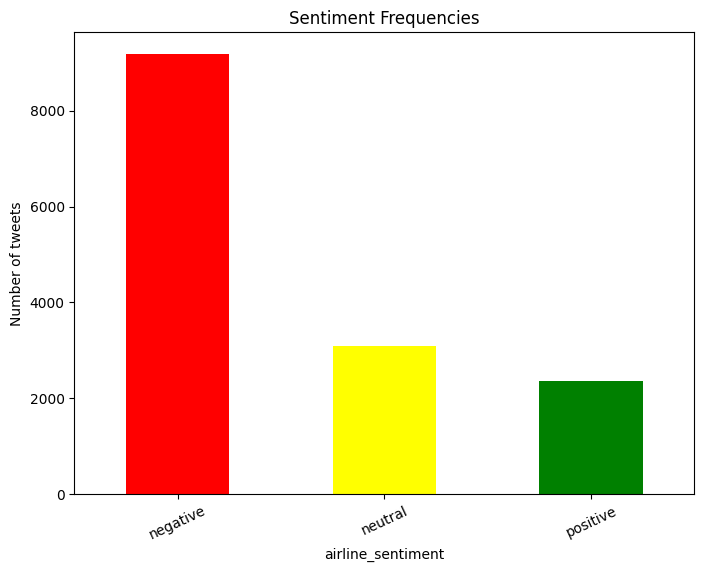

In [4]:
sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Frequencies')
plt.ylabel('Number of tweets')
plt.xticks(rotation=25)
plt.show()

In [5]:
for sentiment, count in sentiment_counts.items():
    print(f"There are {count} tweets with {sentiment} sentiment.")

There are 9178 tweets with negative sentiment.
There are 3099 tweets with neutral sentiment.
There are 2363 tweets with positive sentiment.


As we see, there are a lot of negative tweets about airlines, I think it is pretty normal as people are mostlikely going to say something when it is bad then when it is good. When it is good, it is "normal" for the passenger and does not require to say anything about it. But when it is really really good, they are going to say it. 

For the neutral ones, I do not really know if the dataset is mislabeled. I will try to read some of them later to check.

#### 1.3 - Frequencies of negative sentiment by Airlines

For fun, let's see which company has the most negative tweets. 

In [6]:
sentiment_by_company = df.groupby(['airline', 'airline_sentiment']).size().unstack()

sentiment_by_company

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


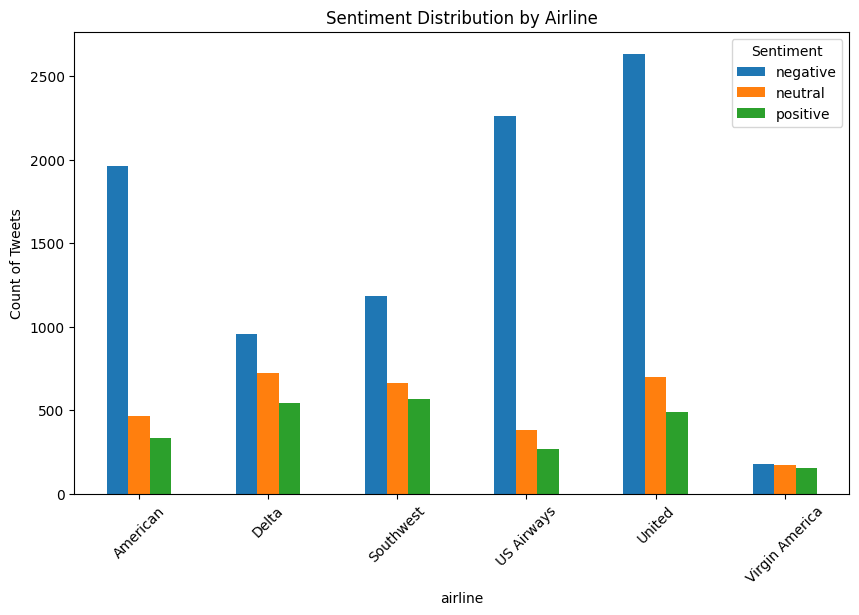

In [7]:
sentiment_by_company.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Sentiment Distribution by Airline')
plt.ylabel('Count of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

In [8]:
negative_tweets_by_company = sentiment_by_company["negative"]
total_tweets_by_company = sentiment_by_company.sum(axis=1)
negative_tweet_rate = (negative_tweets_by_company / total_tweets_by_company).sort_values(ascending=False)

print("Rate of Negative Tweets by Companies:")
print(negative_tweet_rate)

Rate of Negative Tweets by Companies:
airline
US Airways        0.776862
American          0.710402
United            0.688906
Southwest         0.490083
Delta             0.429793
Virgin America    0.359127
dtype: float64


We can see that passengers seem to not like US Airways, American Airlines, United Airlines. Delta Airlines seems to be less hated. About Virgin America, we can't really say anything as there are only around 500 tweets about this company.